In [1]:
import torch
from tqdm import tqdm
from torch import nn, optim
from torch.nn import init
import pandas as pd
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("../../data2/data.csv").drop(columns = ["id", "source", 
                                                       "latitude", "longitude"])

In [2]:
class TabularFFNNSimple(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob=0.4):
        super(TabularFFNNSimple, self).__init__()
        hidden_size = 128
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
#             nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.25),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.18),
            nn.Linear(hidden_size, output_size)
        )
        
        for m in self.ffnn:
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0)

    def forward(self, x):
        x = x.float()
        # print(x)
        x = x.view(x.size(0), -1)
        x = self.ffnn(x)
        return x
    
# Split the data into features and target
X = data.drop('price', axis=1)
y = data['price']

# Standardize the features
device = torch.device("cpu")
# Convert to PyTorch tensors
X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# Split the data into training and combined validation and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
                                                            test_size=0.4, random_state=42)

# Split the combined validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Create DataLoader for training, validation, and testing
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 512
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Check if the dimensions match the expected input size for the model
input_size = X_train.shape[1]

# Output
# input_size, train_loader, test_loader

model = TabularFFNNSimple(
    input_size = input_size,
    output_size = 1
)
model.to(device)

num_epochs = 300000
train_losses = []
val_losses = []
epochs_suc = [] # to have a reference to it
grad_norms = []

def get_gradient_norm(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

In [ ]:
optimizer = optim.Adam(
    model.parameters(), 
    lr=9e-3,
    weight_decay=3e-4
)
criterion = torch.nn.MSELoss()
criterion_abs = torch.nn.L1Loss()
criterion = criterion_abs

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.999999, 
    patience=5, 
    verbose=True
)

for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    running_loss = 0.0
    l1_losses = []
    grad_norm = 0
    for tuple_ in train_loader:
        datas, prices = tuple_
        optimizer.zero_grad()
        outputs = model(datas)
        prices_viewed = prices.view(-1, 1).float()
        loss = criterion(outputs, prices_viewed)
        loss.backward()
        grad_norm += get_gradient_norm(model)
        optimizer.step()

        running_loss += loss.item()
        
    grad_norms.append(grad_norm / len(train_loader))
    train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for tuple_ in val_loader:
            datas, prices = tuple_
            outputs = model(datas)  # Forward pass
            prices_viewed = prices.view(-1, 1).float()
            loss = criterion(outputs, prices_viewed)  # Compute loss
            val_loss += loss.item()  # Accumulate the loss
            l1_losses.append(criterion_abs(outputs, prices_viewed))

    val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
    l1_mean_loss = sum(l1_losses) / len(l1_losses)
    # Print epoch's summary
    epochs_suc.append(epoch)
    scheduler.step(val_losses[-1])
    if epoch % 100 == 0:
        tl = f"Training Loss: {int(train_losses[-1])}"
        vl = f"Validation Loss: {int(val_losses[-1])}"
        l1 = f"L1: {int(l1_mean_loss)}"
        dl = f'Epoch {epoch+1}, {tl}, {vl}, {grad_norms[-1]}'
        print(dl)

Epoch 1, Training Loss: 232829, Validation Loss: 219367, 22349.177082019003
Epoch 101, Training Loss: 74057, Validation Loss: 68965, 50543.03957530964
Epoch 201, Training Loss: 61295, Validation Loss: 58932, 178210.92970457106
Epoch 301, Training Loss: 59647, Validation Loss: 57785, 64008.6924794747
Epoch 401, Training Loss: 64578, Validation Loss: 56704, 214335.29304210618
Epoch 501, Training Loss: 55228, Validation Loss: 55876, 60887.71302015699
Epoch 601, Training Loss: 55177, Validation Loss: 55402, 103738.64177344699
Epoch 701, Training Loss: 60077, Validation Loss: 55466, 119474.54352235094
Epoch 801, Training Loss: 55559, Validation Loss: 54062, 206692.00722229996
Epoch 901, Training Loss: 53394, Validation Loss: 54308, 163946.1793780567
Epoch 1001, Training Loss: 57680, Validation Loss: 53509, 235268.71356897787
Epoch 1101, Training Loss: 57279, Validation Loss: 55570, 243130.9765333326
Epoch 1201, Training Loss: 54626, Validation Loss: 54811, 191187.3834397071
Epoch 1301, Trai

Epoch 10701, Training Loss: 49255, Validation Loss: 53990, 143543.29165051194
Epoch 10801, Training Loss: 52713, Validation Loss: 51064, 188340.33465374215
Epoch 10901, Training Loss: 49737, Validation Loss: 56895, 183852.99035966877
Epoch 11001, Training Loss: 49519, Validation Loss: 50559, 140689.82230764837
Epoch 11101, Training Loss: 49410, Validation Loss: 52038, 132892.63027397
Epoch 11201, Training Loss: 49108, Validation Loss: 50974, 163271.07487769713
Epoch 11301, Training Loss: 51883, Validation Loss: 53439, 137019.8820279768
Epoch 11401, Training Loss: 51001, Validation Loss: 58787, 245970.79325116044
Epoch 11501, Training Loss: 47739, Validation Loss: 51301, 129060.02318649231
Epoch 11601, Training Loss: 50817, Validation Loss: 52104, 159320.9952053129
Epoch 11701, Training Loss: 49765, Validation Loss: 52837, 149079.91865949714
Epoch 11801, Training Loss: 49395, Validation Loss: 50557, 145922.81046809087
Epoch 11901, Training Loss: 49089, Validation Loss: 54877, 205792.276

Epoch 21301, Training Loss: 46648, Validation Loss: 63996, 133832.3593243845
Epoch 21401, Training Loss: 49579, Validation Loss: 61850, 214692.2160737752
Epoch 21501, Training Loss: 50150, Validation Loss: 61781, 120474.67116338639
Epoch 21601, Training Loss: 52754, Validation Loss: 70237, 267931.70315019734
Epoch 21701, Training Loss: 50549, Validation Loss: 64195, 206562.106649993
Epoch 21801, Training Loss: 49749, Validation Loss: 63124, 160479.016491798
Epoch 21901, Training Loss: 47670, Validation Loss: 62808, 117626.86030364018
Epoch 22001, Training Loss: 47929, Validation Loss: 66096, 132509.69929008777
Epoch 22101, Training Loss: 50414, Validation Loss: 66662, 170173.41530489127
Epoch 22201, Training Loss: 49954, Validation Loss: 62829, 139206.28858186843
Epoch 22301, Training Loss: 50997, Validation Loss: 62667, 166762.41053838935
Epoch 22401, Training Loss: 46926, Validation Loss: 65401, 146263.82208362964
Epoch 22501, Training Loss: 50680, Validation Loss: 64901, 164137.4862

Epoch 31901, Training Loss: 45744, Validation Loss: 66620, 157266.67706109406
Epoch 32001, Training Loss: 45898, Validation Loss: 66063, 126727.41082603457
Epoch 32101, Training Loss: 47701, Validation Loss: 64092, 156618.3444245908
Epoch 32201, Training Loss: 50953, Validation Loss: 62484, 209742.99957705537
Epoch 32301, Training Loss: 48335, Validation Loss: 67814, 162741.6347830687
Epoch 32401, Training Loss: 48970, Validation Loss: 68953, 145679.0894640476
Epoch 32501, Training Loss: 48659, Validation Loss: 71491, 150878.70406877596
Epoch 32601, Training Loss: 47607, Validation Loss: 71415, 163387.9577036579
Epoch 32701, Training Loss: 46541, Validation Loss: 71818, 248471.44419123503
Epoch 32801, Training Loss: 49978, Validation Loss: 70524, 217107.3924135863
Epoch 32901, Training Loss: 50625, Validation Loss: 75290, 125866.45453808899
Epoch 33001, Training Loss: 53815, Validation Loss: 71346, 158417.16106232884
Epoch 33101, Training Loss: 47849, Validation Loss: 68380, 109969.747

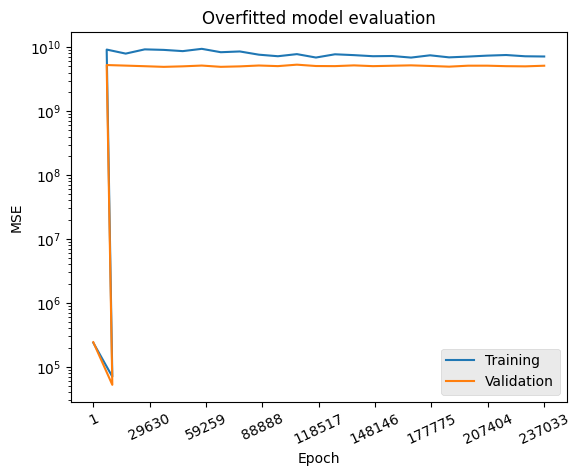

In [29]:
import matplotlib.pyplot as plt

train_losses_sampled = train_losses[::10000]  # Select every 1000th value
val_losses_sampled = val_losses[::10000]      # Select every 1000th value

# Generate corresponding epoch numbers, assuming epochs_suc is your list of epoch numbers
epochs_sampled = epochs_suc[::10000]

plt.title("Overfitted model evaluation")
plt.style.use("ggplot")

# Use sampled data for plotting
plt.plot(epochs_sampled, train_losses_sampled, label='Training')
plt.plot(epochs_sampled, val_losses_sampled, label='Validation')

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.yscale('log')
plt.xticks(
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    rotation = 25
)
plt.legend()
plt.show()
# plt.savefig("../visualizations/overfit_model_evaluation_full_dataset.png", dpi=800)

# Saving. Good results

In [ ]:
# class TabularFFNNSimple(nn.Module):
#     def __init__(self, input_size, output_size, dropout_prob=0.4):
#         super(TabularFFNNSimple, self).__init__()
#         hidden_size = 48
#         self.ffnn = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU(),
# #             nn.BatchNorm1d(hidden_size),
# #             nn.Dropout(0.5),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
# #             nn.Dropout(0.5),
#             nn.Linear(hidden_size, output_size)
#         )
        
#         for m in self.ffnn:
#             if isinstance(m, nn.Linear):
#                 init.xavier_uniform_(m.weight)
#                 m.bias.data.fill_(0)

#     def forward(self, x):
#         x = x.float()
#         # print(x)
#         x = x.view(x.size(0), -1)
#         x = self.ffnn(x)
#         return x
    
# # Split the data into features and target
# X = data.drop('price', axis=1)
# y = data['price']

# # Standardize the features
# device = torch.device("cpu")
# # Convert to PyTorch tensors
# X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
# y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# # Split the data into training and combined validation and testing sets
# X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
#                                                             test_size=0.4, random_state=42)

# # Split the combined validation and testing sets
# X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# # Create DataLoader for training, validation, and testing
# train_data = TensorDataset(X_train, y_train)
# val_data = TensorDataset(X_val, y_val)
# test_data = TensorDataset(X_test, y_test)

# batch_size = 256
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# # Check if the dimensions match the expected input size for the model
# input_size = X_train.shape[1]

# # Output
# # input_size, train_loader, test_loader

# model = TabularFFNNSimple(
#     input_size = input_size,
#     output_size = 1
# )
# model.to(device)

# num_epochs = 300000
# train_losses = []
# val_losses = []
# epochs_suc = [] # to have a reference to it
# grad_norms = []

# def get_gradient_norm(model):
#     total_norm = 0
#     for p in model.parameters():
#         if p.grad is not None:
#             param_norm = p.grad.data.norm(2)
#             total_norm += param_norm.item() ** 2
#     total_norm = total_norm ** 0.5
#     return total_norm

# optimizer = optim.Adam(
#     model.parameters(), 
#     lr=9e-3,
#     weight_decay=1e-4
# )
# criterion = torch.nn.MSELoss()
# criterion_abs = torch.nn.L1Loss()
# criterion = criterion_abs

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='min', 
#     factor=0.999999, 
#     patience=10, 
#     verbose=True
# )

# for epoch in range(num_epochs):
#     # Training
#     model.train()  # Set the model to training mode
#     running_loss = 0.0
#     l1_losses = []
#     grad_norm = 0
#     for tuple_ in train_loader:
#         datas, prices = tuple_
#         optimizer.zero_grad()
#         outputs = model(datas)
#         prices_viewed = prices.view(-1, 1).float()
#         loss = criterion(outputs, prices_viewed)
#         loss.backward()
#         grad_norm += get_gradient_norm(model)
#         optimizer.step()

#         running_loss += loss.item()
        
#     grad_norms.append(grad_norm / len(train_loader))
#     train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

#     # Validation
#     model.eval()  # Set the model to evaluation mode
#     val_loss = 0.0
#     with torch.no_grad():  # Disable gradient calculation
#         for tuple_ in val_loader:
#             datas, prices = tuple_
#             outputs = model(datas)  # Forward pass
#             prices_viewed = prices.view(-1, 1).float()
#             loss = criterion(outputs, prices_viewed)  # Compute loss
#             val_loss += loss.item()  # Accumulate the loss
#             l1_losses.append(criterion_abs(outputs, prices_viewed))

#     val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
#     l1_mean_loss = sum(l1_losses) / len(l1_losses)
#     # Print epoch's summary
#     epochs_suc.append(epoch)
#     scheduler.step(val_losses[-1])
#     if epoch % 100 == 0:
#         tl = f"Training Loss: {int(train_losses[-1])}"
#         vl = f"Validation Loss: {int(val_losses[-1])}"
#         l1 = f"L1: {int(l1_mean_loss)}"
#         dl = f'Epoch {epoch+1}, {tl}, {vl}, {grad_norms[-1]}'
#         print(dl)